# HW 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans

## Exercise 1

In [2]:
# Read the CSV file
df = pd.read_csv("data_ex1_wt.csv")
print(df.shape)

(27199, 2)


### Problem 1

Draw a scatter plot and verify that there is a trend in the data.

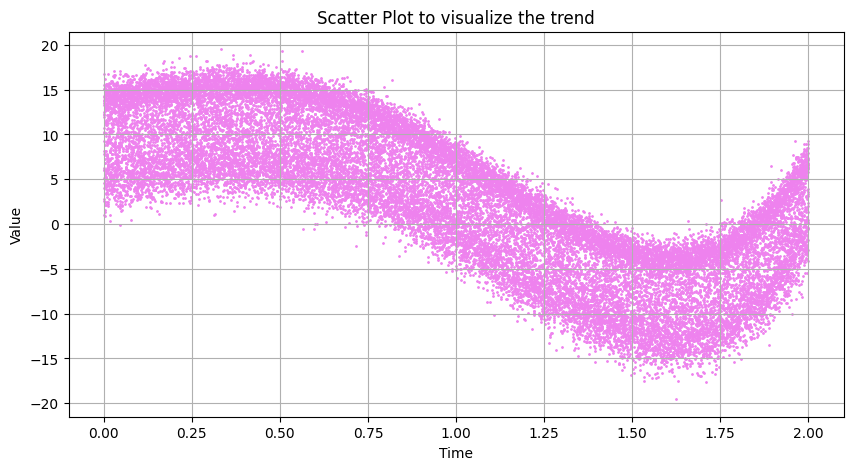

In [3]:
# Display the time series data with a scatter plot

plt.figure(figsize=(10, 5))
plt.scatter(df["time"], df["value"], color="violet", s=1)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Scatter Plot to visualize the trend")
plt.show()

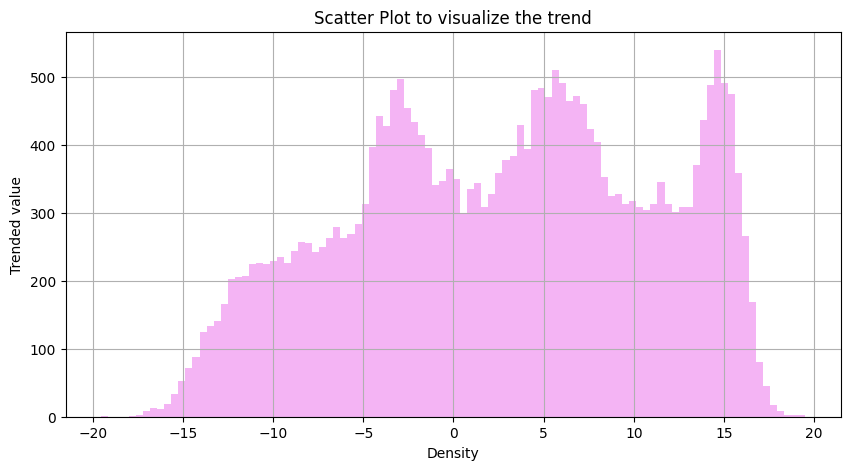

In [4]:
plt.figure(figsize=(10, 5))
plt.hist(df["value"], color="violet", alpha=0.6, bins=100)
plt.grid(True)
plt.xlabel("Density")
plt.ylabel("Trended value")
plt.title("Scatter Plot to visualize the trend")
plt.show()

### Problem 2

Use least squares to estimate the coefficient of a polynomial trend function, and remove the trend.

In [5]:
def poly_reg(deg, x, y):

    # Create the vandermonde matrix
    A = np.vander(x, N=deg + 1, increasing=True)

    # Fit the polynomial regression with least squares
    b, sq_residuals, _, _ = np.linalg.lstsq(A, y, rcond=None)
    y_fit = A @ b
    return y_fit, sq_residuals

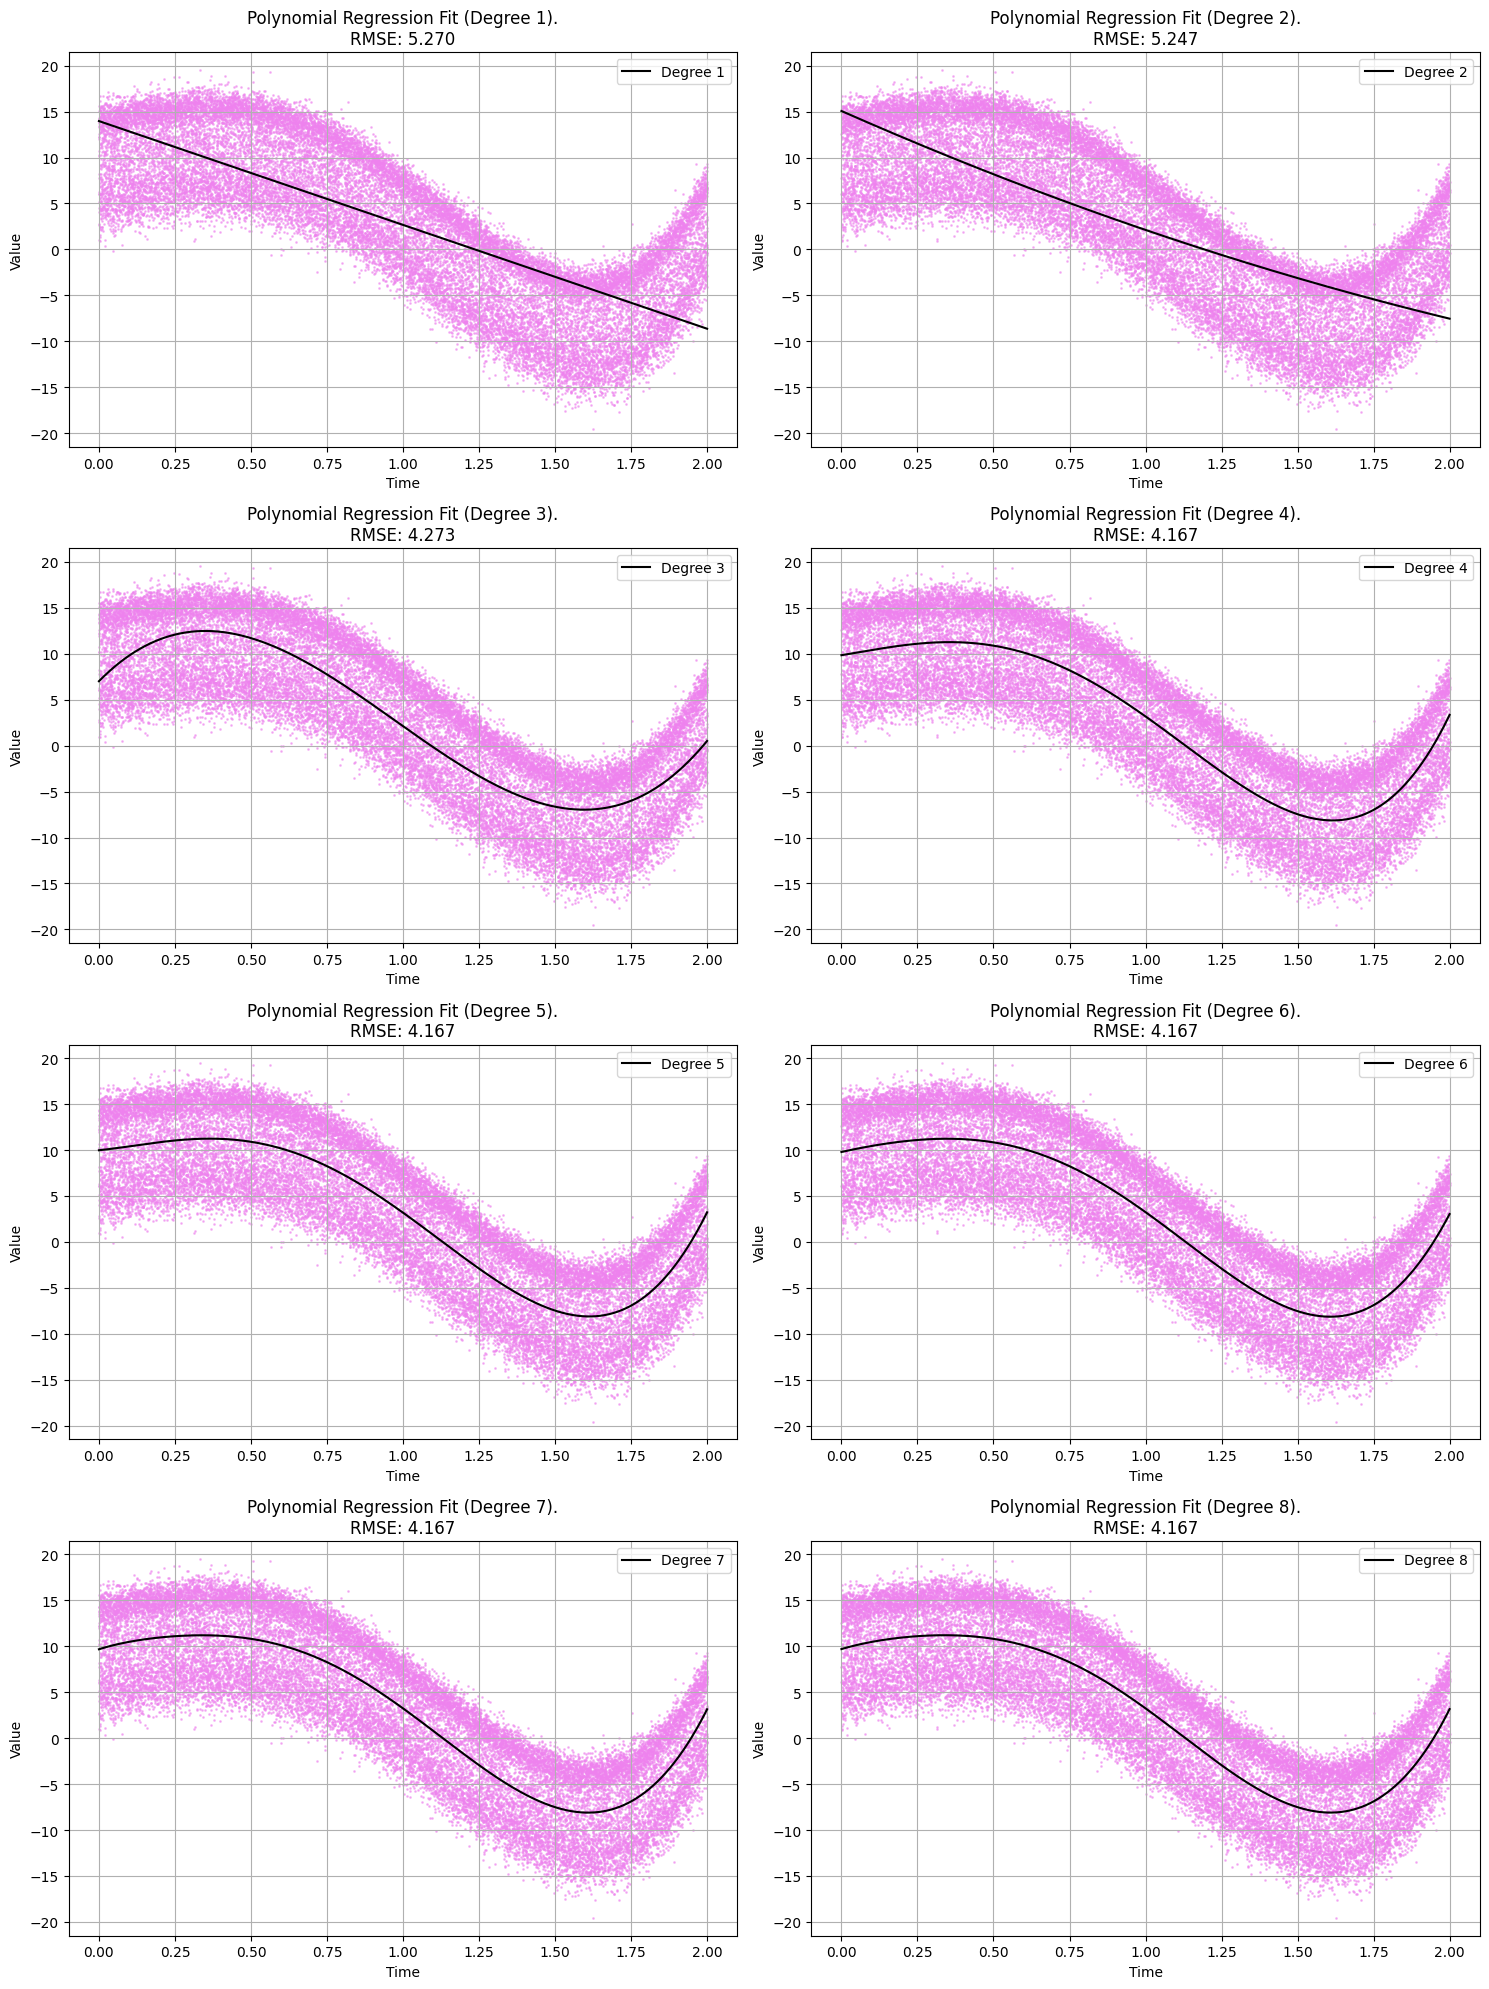

In [6]:
MAX_DEGREE = 8
# Compute the coefficients of polynomial regression from 1 to MAX_DEGREE and plot the results

times = df["time"].values
vals = df["value"].values

n_plots = MAX_DEGREE
cols = 2
rows = math.ceil(n_plots / cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

degrees = range(1, MAX_DEGREE + 1)

rmse_for_degrees = []

for deg in degrees:
    trend, sq_residuals = poly_reg(deg, times, vals)

    # Compute RMSE
    rmse = np.sqrt(sq_residuals / len(vals))
    rmse_for_degrees.append(rmse)

    # Plot the results
    ax = axes[deg - 1]
    ax.scatter(times, vals, color="violet", alpha=0.5, s=1)
    ax.plot(times, trend, color="black", label=f"Degree {deg}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.set_title(
        f"Polynomial Regression Fit (Degree {deg}).\nRMSE: {float(rmse[0]):.3f}"
    )
    ax.grid()
    ax.legend()

for ax in axes[n_plots:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

### Problem 3

After having veriﬁed that you only need powers up to 5, remove the trend from the data and show the
histogram of the resulting dataset.

In [7]:
# Using cross validation to confirm the best model in term of generalization
times_cv = df["time"].values.reshape(-1, 1)
vals_cv = df["value"].values

rmse_cv = []
rmse_cv_std = []
best_rmse_cv = float("inf")
best_poly = None
# best_model = None

for deg in degrees:
    poly = PolynomialFeatures(
        degree=deg, include_bias=True, interaction_only=False
    )  # transformer for genearting the feature matrix (A)
    X_poly = poly.fit_transform(times_cv)  # matrix A
    model = LinearRegression()

    # Use negative RMSE and reverse its sign
    scores = -cross_val_score(
        model, X_poly, vals_cv, cv=5, scoring="neg_root_mean_squared_error"
    )
    current_rmse = scores.mean()
    rmse_cv.append(current_rmse)
    rmse_cv_std.append(scores.std())
    if current_rmse < best_rmse_cv:
        best_rmse_cv = current_rmse
        best_poly = poly
        # best_model = model.fit(X_poly, y_cv)

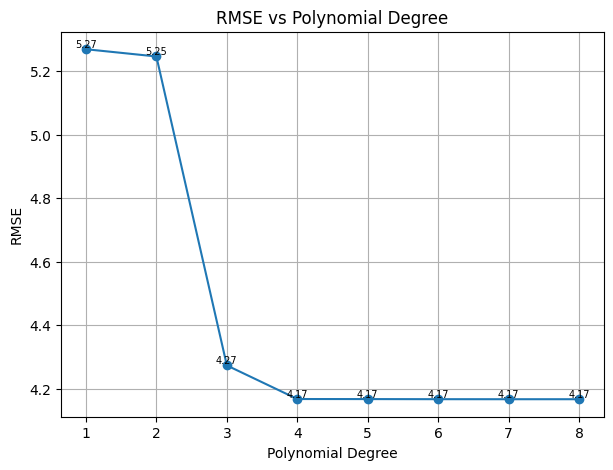

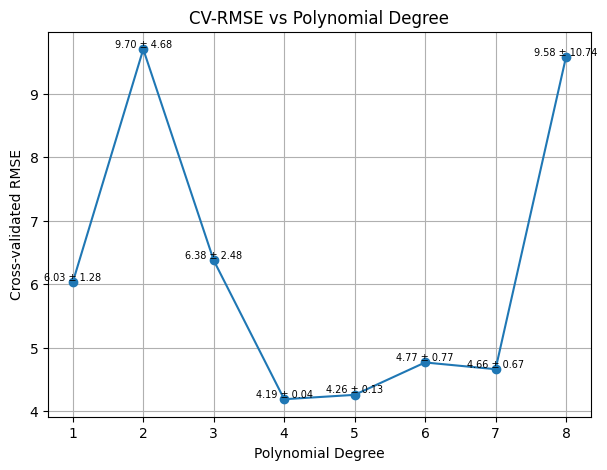

Best model degree:  4


In [8]:
# RMSE vs Polynomial Degree on the second subplot
rmse_floats = [float(r[0]) for r in rmse_for_degrees]
plt.figure(figsize=(7, 5))
plt.plot(degrees, rmse_floats, marker="o")

for deg, rm in zip(degrees, rmse_floats):
    plt.text(deg, rm, f"{rm:.2f}", ha="center", va="bottom", fontsize=7)
plt.xlabel("Polynomial Degree")
plt.ylabel("RMSE")
plt.title("RMSE vs Polynomial Degree")
plt.grid(True)
plt.show()

# CV-MSE vs Polynomial Degree on the first subplot
plt.figure(figsize=(7, 5))
plt.plot(degrees, rmse_cv, marker="o")

for d_val, cv_rmse, std in zip(degrees, rmse_cv, rmse_cv_std):
    plt.text(
        d_val,
        cv_rmse,
        f"{cv_rmse:.2f} ± {std:.2f}",
        ha="center",
        va="bottom",
        fontsize=7,
    )
plt.xlabel("Polynomial Degree")
plt.ylabel("Cross-validated RMSE")
plt.title("CV-RMSE vs Polynomial Degree")
plt.grid(True)

plt.show()

print("Best model degree: ", best_poly.degree)

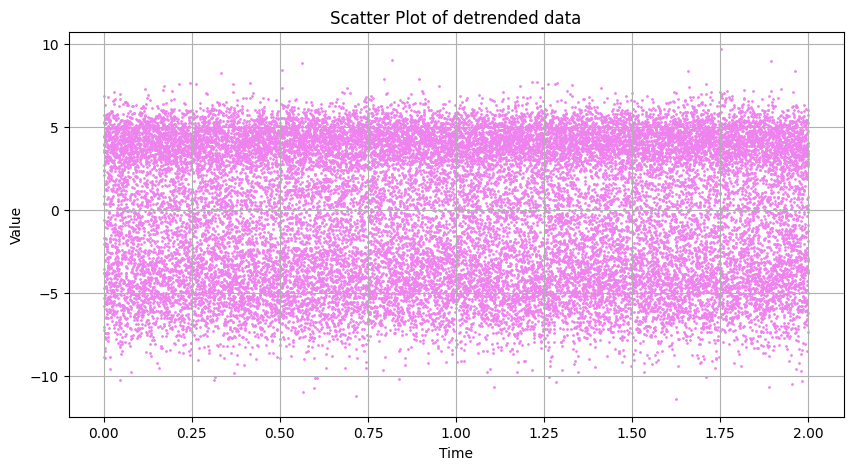

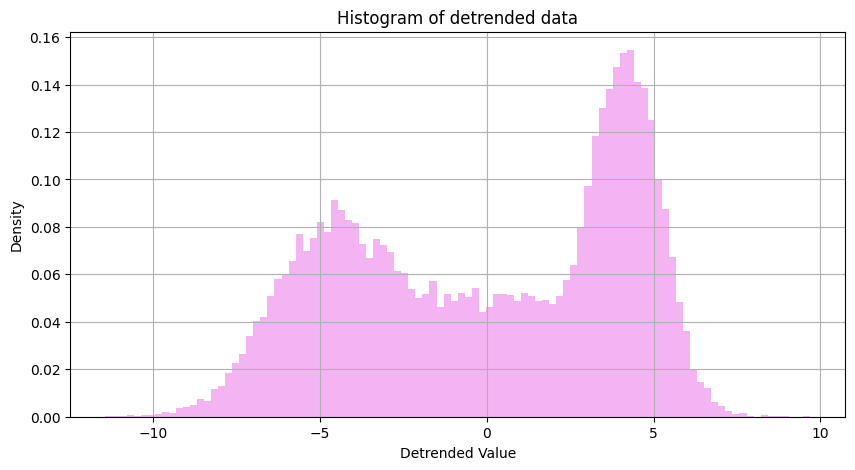

In [9]:
# removing the trend of the data
trend, _ = poly_reg(best_poly.degree, times, vals)

y_detrended = vals - trend

# Plot the detrended data
plt.figure(figsize=(10, 5))
plt.scatter(df["time"], y_detrended, color="violet", s=1)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Scatter Plot of detrended data")
plt.show()

# Plot distribution of detrended data
plt.figure(figsize=(10, 5))
plt.hist(y_detrended, color="violet", bins=100, alpha=0.6, density=True)
plt.grid(True)
plt.xlabel("Detrended Value")
plt.ylabel("Density")
plt.title("Histogram of detrended data")
plt.show()

### Problem 4

Implement the Expectation-Maximization algorithm to fit a mixture of three Gaussian distributions to
the data. Give the mean and variance of the distributions thus found, and plot the corresponding PDFs
on top of the empirical PDF of the data (e.g., the histogram).

In [10]:
def EM(
    X: np.ndarray,
    K: int,
    prior: np.ndarray,
    mu: np.ndarray,
    sigma: np.ndarray,
    max_iter: int = int(1e9),
    tol: float = 1e-6,
):
    """
    EM algorithm for Gaussian Mixture Model (GMM) clustering.

    Args:
        X (ndarray): Input data, shape (N, D) where N is the number of samples and D is the number of features.
        K (int): Number of clusters.
        prior (ndarray): Initial prior probabilities for each cluster, shape (K,).
        mu_arr (ndarray): Initial means for each cluster, shape (K, D).
        sigma_arr (ndarray): Initial standard deviations for each cluster, shape (K, D).
        max_iter (int): Maximum number of iterations for EM algorithm.
        tol (float): Tolerance for convergence.
    Returns:
        prior (ndarray): Updated prior probabilities for each cluster, shape (K,).
        mu_arr (ndarray): Updated means for each cluster, shape (K, D).
        sigma_arr (ndarray): Updated standard deviations for each cluster, shape (K, D).
        iteration (int): Number of iterations until convergence or max_iter.

    """

    N = X.shape[0]  # number of samples

    loglikelihood_old = -np.inf

    for iteration in range(max_iter):
        # ---- E-step----
        gamma = np.zeros((N, K))
        for k in range(K):
            # weight by prior and likelihood
            gamma[:, k] = prior[k] * stats.norm.pdf(X, mu[k], sigma[k])
        # normalize so each row sums to 1
        gamma /= gamma.sum(axis=1, keepdims=True)

        # ---- M-step----
        N_k = gamma.sum(axis=0)  # number of samples in each cluster
        mu = np.array(
            [(gamma[:, k] * X).sum() / N_k[k] for k in range(K)]
        )  # update means
        sigma = np.array(
            [np.sqrt((gamma[:, k] * (X - mu[k]) ** 2).sum() / N_k[k]) for k in range(K)]
        )  # update std_dev
        prior = N_k / N  # update priors

        # ---- Compute log-likelihood ----
        pdfs = np.vstack(
            [prior[k] * stats.norm.pdf(X, mu[k], sigma[k]) for k in range(K)]
        )  # shape (K, N)

        loglikelihood = np.sum(np.log(pdfs.sum(axis=0)))

        # Check convergence in log-likelihood
        if (
            loglikelihood_old is not None
            and abs(loglikelihood - loglikelihood_old) < tol
        ):
            break

        # Othewise update the old log-likelihood and continue
        loglikelihood_old = loglikelihood

    iteration = iteration + 1 if iteration < max_iter - 1 else -1
    return prior, mu, sigma, iteration

In [11]:
# Prepare data: X2d for clustering, X for EM fitting
X2d = y_detrended.reshape(-1, 1)  # 2D array of shape (N, 1) for KMeans
X = y_detrended

K = 3  # number of mixture components

# EM algorithm settings
max_iter = 1000
tol = 1e-6

# Initialization via KMeans to get starting means and cluster assignments
kmeans = KMeans(n_clusters=K).fit(X2d)
init_mu_km = kmeans.cluster_centers_.flatten()  # initial means from centroids
labels = kmeans.labels_  # cluster labels for each sample

init_sigma_km = np.array(
    [np.sqrt(np.mean(np.sum((X[labels == k] - kmeans.cluster_centers_[k])**2)))
    for k in range(K)]
)  # estimate intra-cluster variances

init_prior_km = (
    np.array([np.sum(labels == k) for k in range(K)]) / X.shape[0]
)  # prior estimated as the fraction of points in each cluster

# EM with kmeans initialization
prior_km, mu_km, sigma_km, iteration_km = EM(
    X, K, init_prior_km, init_mu_km, init_sigma_km, max_iter, tol
)
print("Final parameters with KMeans initialization:")
print(
    f"Converged at iteration {iteration_km if iteration_km >= 0 else "MAX ITERATIONS REACHED"}"
)
for k in range(K):
    print(
        f"Component {k+1}: Weight = {prior_km[k]:.4f}, Mean = {mu_km[k]:.4f}, Var = {sigma_km[k]**2:.4f}"
    )

# EM with random initialization
init_prior_rand = np.ones(K) / K
init_mu_rand = np.random.choice(X, K)
init_sigma_rand = np.full(K, np.std(X))

prior_rand, mu_rand, sigma_rand, iteration_rand = EM(
    X, K, init_prior_rand, init_mu_rand, init_sigma_rand, max_iter, tol
)

print(
    "---------------------------------------------------------------------------------------"
)
print("Final parameters with random initialization:")
print(f"Converged at iteration {iteration_rand if iteration_rand >= 0 else "MAX_ITER"}")
for k in range(K):
    print(
        f"Component {k+1}: Weight = {prior_rand[k]:.4f}, Mean = {mu_rand[k]:.4f}, Var = {sigma_rand[k]**2:.4f}"
    )

Final parameters with KMeans initialization:
Converged at iteration 569
Component 1: Weight = 0.3534, Mean = 4.2616, Var = 0.9841
Component 2: Weight = 0.3443, Mean = -4.7274, Var = 3.0625
Component 3: Weight = 0.3024, Mean = 0.4021, Var = 5.9683
---------------------------------------------------------------------------------------
Final parameters with random initialization:
Converged at iteration 473
Component 1: Weight = 0.3024, Mean = 0.4021, Var = 5.9683
Component 2: Weight = 0.3443, Mean = -4.7274, Var = 3.0625
Component 3: Weight = 0.3534, Mean = 4.2616, Var = 0.9841


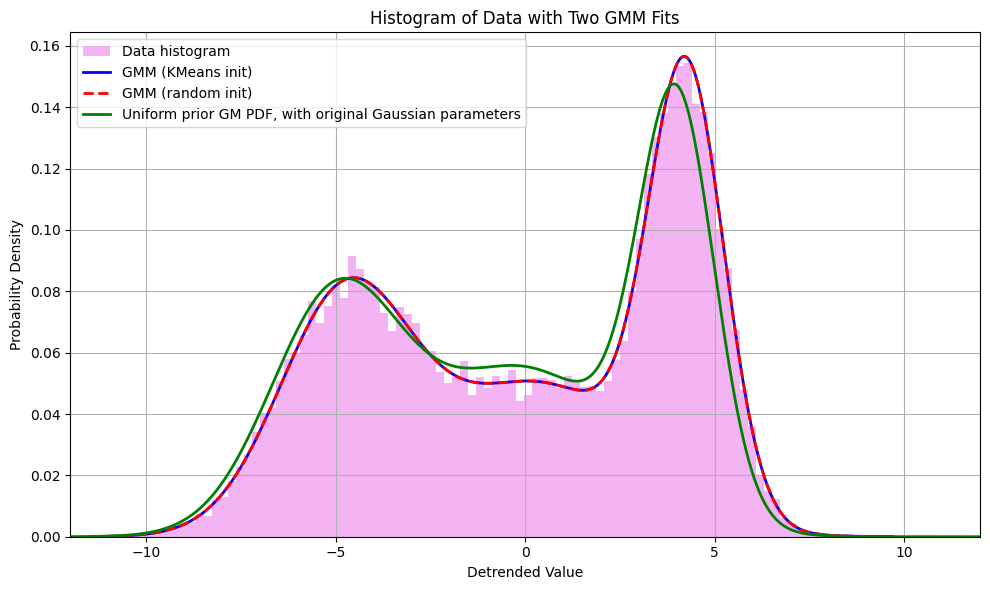

In [12]:
# Create a fine grid over the data range
x_vals = np.linspace(X.min(), X.max(), 500)

# Compute the mixture density for each fitted model
pdf_km = np.zeros_like(x_vals)
pdf_rand = np.zeros_like(x_vals)
for k in range(K):
    # KMeans‐initialized GMM
    pdf_km += (
        prior_km[k]
        * (1 / np.sqrt(2 * np.pi * sigma_km[k] ** 2))
        * np.exp(-((x_vals - mu_km[k]) ** 2) / (2 * sigma_km[k] ** 2))
    )
    # Random‐initialized GMM
    pdf_rand += (
        prior_rand[k]
        * (1 / np.sqrt(2 * np.pi * sigma_rand[k] ** 2))
        * np.exp(-((x_vals - mu_rand[k]) ** 2) / (2 * sigma_rand[k] ** 2))
    )


plt.figure(figsize=(10, 6))
plt.hist(X, bins=100, density=True, alpha=0.6, label="Data histogram", color="violet")
plt.plot(x_vals, pdf_km, label="GMM (KMeans init)", linewidth=2, color="blue")
plt.plot(
    x_vals,
    pdf_rand,
    label="GMM (random init)",
    linestyle="--",
    linewidth=2,
    color="red",
)


# Gaussian PDFs for the given parameters (mean, variance), assuming the priors are uniform
gaussian_params = [(-5, 3), (4, 1), (0, 6)]
x_range = np.linspace(-15, 15, 500)
pdf = np.zeros_like(x_range)

# plt.figure(figsize=(10,6))
for mu, var in gaussian_params:
    pdf += (1 / 3) * (
        1 / np.sqrt(2 * np.pi * var) * np.exp(-((x_range - mu) ** 2) / (2 * var))
    )
plt.plot(
    x_range,
    pdf,
    color="green",
    label="Uniform prior GM PDF, with original Gaussian parameters",
    linewidth=2,
)
plt.xlim(-12, 12)
plt.xlabel("Detrended Value")
plt.ylabel("Probability Density")
plt.title("Histogram of Data with Two GMM Fits")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Problem 5

Facultative: can you devise an algorithm to automatically establish that the best number of Gaussian
distributions to ﬁt the de-trended dataset is in fact 3?

In [13]:
def compute_log_likelihood(X, prior, mu, sigma):
    # Compute the log-likelihood of the data under the GMM
    pdf_vals = np.zeros_like(X, dtype=float)
    for k in range(len(prior)):
        pdf_vals += prior[k] * stats.norm.pdf(X, mu[k], sigma[k])
    return np.sum(np.log(pdf_vals))


# Range of K to evaluate
K_candidates = range(1, 11)
penalized_log_likelihoods = []

N = X.shape[0]

for K in K_candidates:
    # Random initialization for EM
    init_prior = np.ones(K) / K
    init_mu = np.random.choice(X, K)
    init_sigma = np.full(K, np.std(X))

    # Run EM with random initialization
    max_iter = 1000
    tol=1e-6
    prior_est, mu_est, sigma_est, iterations = EM(
        X, K, init_prior, init_mu, init_sigma, max_iter=max_iter, tol=tol
    )

    # Compute log-likelihood
    log_likelihood = compute_log_likelihood(X, prior_est, mu_est, sigma_est)

    # Number of parameters = (K-1) for priors + K for means + K for variances: 3K - 1
    num_params = 3 * K - 1
    bic_penalty = np.log(N) * num_params
    penalized_log_likelihood = -2 * log_likelihood + num_params * np.log(N)
    penalized_log_likelihoods.append(penalized_log_likelihood)

    print(
        f"K={K}: Log-Likelihood = {log_likelihood:.2f}, BIC score= {penalized_log_likelihood:.2f} (Converged in {iterations if iterations >=0 else "MAX_ITER"} iterations)"
    )

# Determine best K (minimum BIC)
best_K = K_candidates[np.argmin(penalized_log_likelihoods)]
print("\nBest number of Gaussians (K) according to penalized likelihood:", best_K)

K=1: Log-Likelihood = -77414.62, BIC score= 154849.67 (Converged in 2 iterations)
K=2: Log-Likelihood = -71992.52, BIC score= 144036.09 (Converged in 76 iterations)
K=3: Log-Likelihood = -71391.11, BIC score= 142863.90 (Converged in 438 iterations)
K=4: Log-Likelihood = -71391.07, BIC score= 142894.46 (Converged in MAX_ITER iterations)
K=5: Log-Likelihood = -71391.02, BIC score= 142925.00 (Converged in MAX_ITER iterations)
K=6: Log-Likelihood = -71391.21, BIC score= 142956.01 (Converged in MAX_ITER iterations)
K=7: Log-Likelihood = -71389.62, BIC score= 142983.45 (Converged in MAX_ITER iterations)
K=8: Log-Likelihood = -71389.62, BIC score= 143014.08 (Converged in MAX_ITER iterations)
K=9: Log-Likelihood = -71389.41, BIC score= 143044.30 (Converged in MAX_ITER iterations)
K=10: Log-Likelihood = -71389.65, BIC score= 143075.41 (Converged in MAX_ITER iterations)

Best number of Gaussians (K) according to penalized likelihood: 3


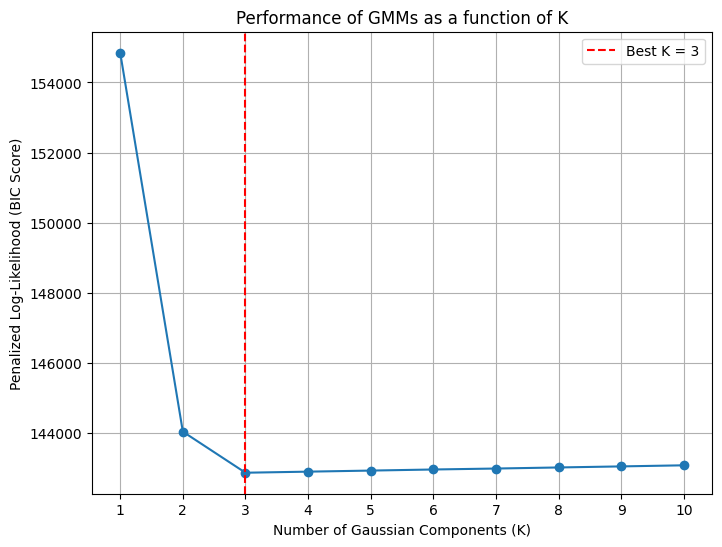

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(list(K_candidates), penalized_log_likelihoods, marker="o", linestyle="-")
plt.xlabel("Number of Gaussian Components (K)")
plt.ylabel("Penalized Log-Likelihood (BIC Score)")
plt.title("Performance of GMMs as a function of K")
plt.xticks(list(K_candidates))
plt.grid(True)
plt.axvline(x=best_K, color="red", linestyle="--", label=f"Best K = {best_K}")
plt.legend()
plt.show()